# Reconnaissance d'écriture manuscrits

## 1. Importations

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

import numpy as np
from tqdm import tqdm # for progress bar
import matplotlib.pyplot as plt # for plotting
from PIL import Image # for image reading
import os
import random

## 2. Configuration du matériel

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

if torch.cuda.is_available():
    print("Le GPU est utilisé")
else:
    print("Le GPU n'est PAS utilisé, le CPU est utilisé")

#? paramètre de matplotlib
# plt.rcParams.update({
#     "figure.facecolor": "#1E1E1E",  # Couleur de fond de la figure
#     "axes.facecolor": "#1E1E1E",    # Couleur de fond des axes
#     "axes.edgecolor": "white",      # Couleur des bords des axes
#     "axes.titlecolor": "white",     # Couleur du titre des axes
#     "axes.labelcolor": "white",     # Couleur des étiquettes des axes
#     "xtick.color": "white",         # Couleur des graduations des abscisses
#     "ytick.color": "white",         # Couleur des graduations des ordonnées
#     "text.color": "white",          # Couleur du texte
# })

Le GPU est utilisé


## 3. Importations des données

In [3]:
batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Chargement des datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Séparation des données d'entraînement en ensembles d'entraînement et de validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Création des DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 4. Exploration des données

In [4]:
print("Forme des données d'entraînement:", train_dataset[0][0].shape)
print("Forme des données de validation:", val_dataset[0][0].shape)
print("Forme des données de test:", test_dataset[0][0].shape)

Forme des données d'entraînement: torch.Size([1, 28, 28])
Forme des données de validation: torch.Size([1, 28, 28])
Forme des données de test: torch.Size([1, 28, 28])


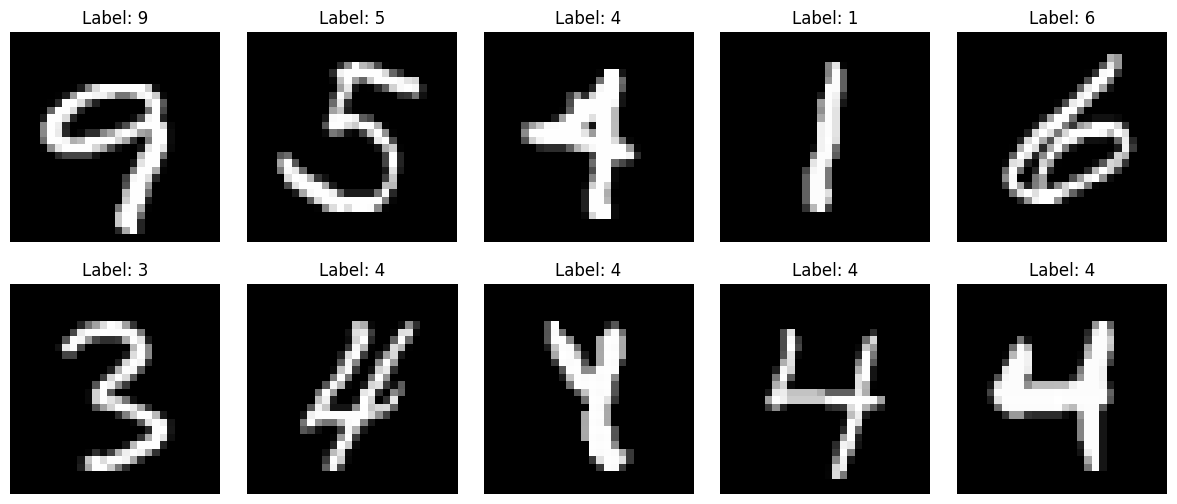

In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

batch_size = len(images)

random_indices = random.sample(range(batch_size), 10)

plt.figure(figsize=(15, 6)) # largeur, hauteur

for i, idx in enumerate(random_indices):
    image = images[idx].squeeze(0).numpy()
    label = labels[idx].item()
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.subplots_adjust(wspace=0.1)
plt.show()

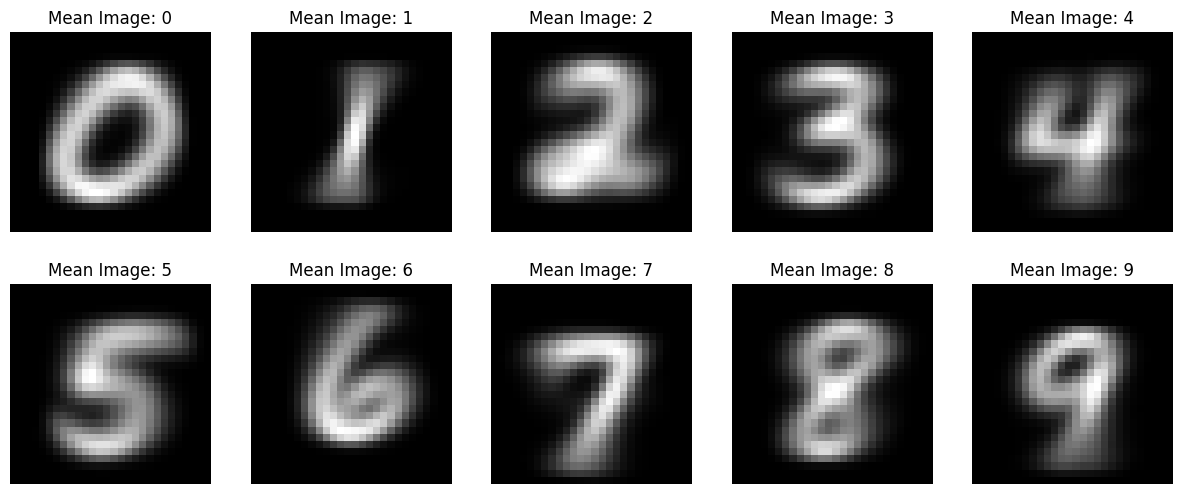

In [6]:
def calculate_mean_images(loader):
    mean_images = {i: torch.zeros((1, 28, 28)) for i in range(10)}
    counts = {i: 0 for i in range(10)}
    
    for images, labels in loader:
        for image, label in zip(images, labels):
            mean_images[label.item()] += image
            counts[label.item()] += 1
    
    for i in range(10):
        mean_images[i] /= counts[i]
    
    return mean_images

mean_images = calculate_mean_images(train_loader)

plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(mean_images[i].squeeze(0), cmap='gray')
    plt.title(f"Mean Image: {i}")
    plt.axis('off')
plt.show()

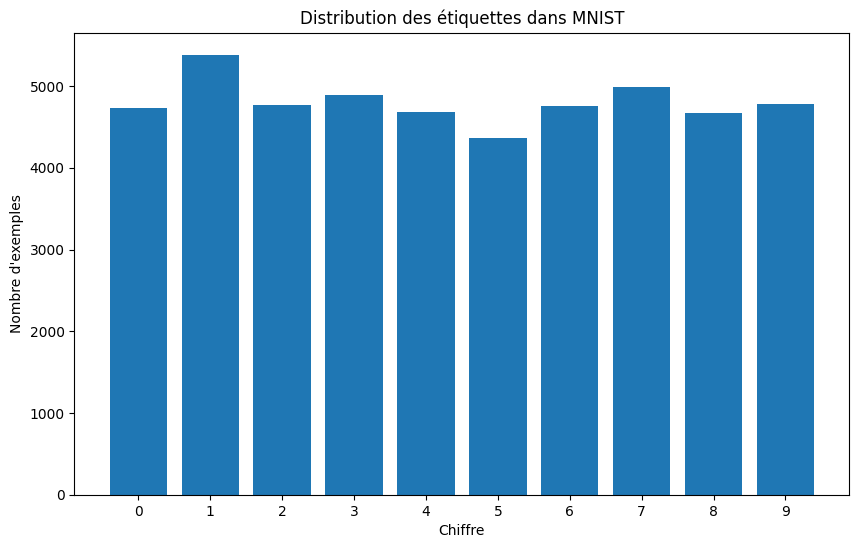

In [7]:
labels = [label for _, labels in train_loader for label in labels]
plt.figure(figsize=(10, 6))
plt.hist(labels, bins=np.arange(-0.5, 10.5, 1), rwidth=0.8)
plt.title("Distribution des étiquettes dans MNIST")
plt.xlabel("Chiffre")
plt.ylabel("Nombre d'exemples")
plt.xticks(np.arange(0, 10, 1))
plt.show()

## 5. Définition de l'architecture du réseau

In [8]:
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=40, output_size=10, num_hidden_layers=4):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size, bias=True))
        for i in range(num_hidden_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size, bias=True))
        self.layers.append(nn.Linear(hidden_size, output_size, bias=True))

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Mettre à plat les images
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x

## 6. Entraînement du modèle!

In [9]:
model = MLP().to(device) # Création du modèle et le charger sur le GPU si disponible
criterion = nn.CrossEntropyLoss() # L& CrossEntropyLoss est notre fonction de perte
optimizer = optim.SGD(model.parameters(), lr=0.01) # lr = learning rate, SGD = Stochastic Gradient Descent

num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    # Entraînement
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_losses.append(train_loss/len(train_loader))
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    val_losses.append(val_loss/len(val_loader))
    # print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

Epoch 20: 100%|██████████| 1500/1500 [00:05<00:00, 293.75it/s]


## 7. Évaluation de l'entraînement

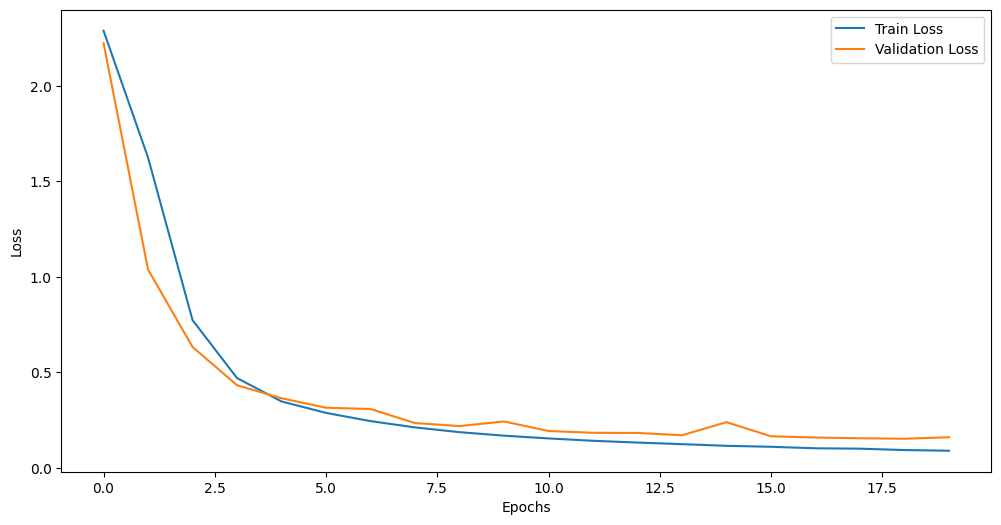

Entraînement terminé


In [10]:
# Affichage des pertes d'entraînement et de validation
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print('Entraînement terminé')

## 8. Prédiction sur l'ensemble de test

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Listes pour stocker les vraies étiquettes et les prédictions
all_labels, all_predictions = [], []

# Évaluation du modèle
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calcul des métriques
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Exactitude sur l\'ensemble de test : {accuracy:.2f}%')
print(f'Precision moyenne : {precision:.2f}')
print(f'Recall moyen : {recall:.2f}')
print(f'Score F1 moyen : {f1:.2f}')


Précision sur l'ensemble de test : 0.96%
Precision moyenne : 0.96
Recall moyen : 0.96
Score F1 moyen : 0.96


## 9. Visualisation des prédictions

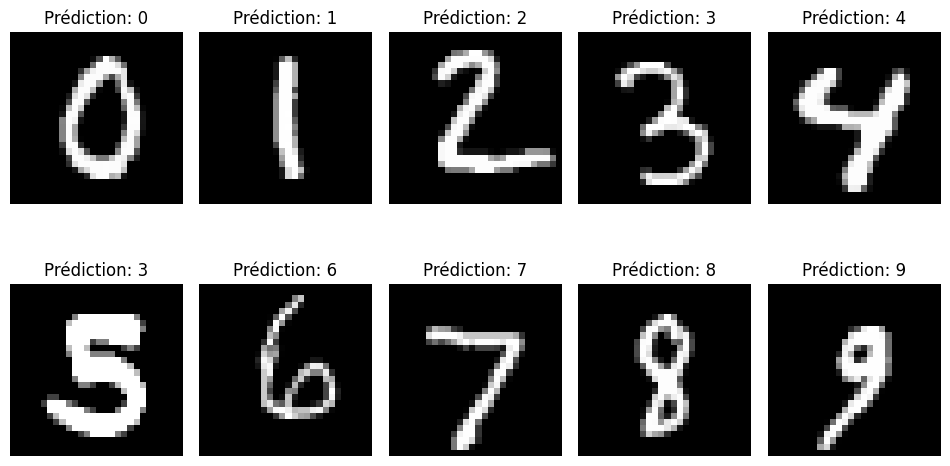

In [15]:
def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert('L') 
    image_tensor = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs.data, 1)
    return predicted.item(), image  # Retournez la prédiction et l'image ouverte

# Répertoire contenant les images à tester
image_directory = "./data/MNIST/testing"

# Listez tous les fichiers dans le répertoire
all_files = os.listdir(image_directory)

image_files = [f for f in all_files if f.endswith('.png')]

# Exécutez la prédiction sur toutes les images
plt.figure(figsize=(12, 6))
for i, image_file in enumerate(image_files[:10]):
    full_image_path = os.path.join(image_directory, image_file)
    prediction, image = predict_image(full_image_path, model, transform) 
    
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Prédiction: {prediction}")
    plt.axis('off') 

plt.subplots_adjust(wspace=0.1)  # Ajustement de l'espace entre les plots
plt.show() 

## Quelques plots du chapitre

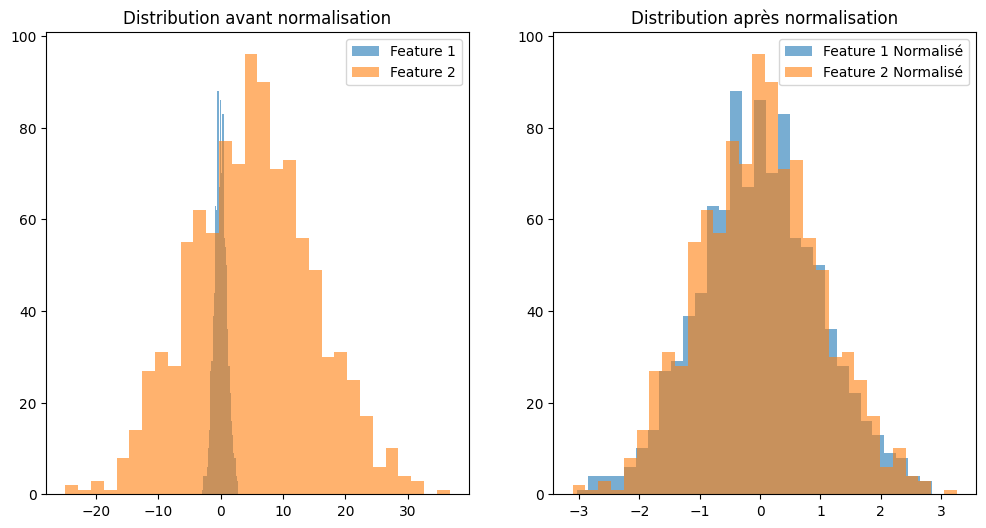

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Génération de données d'exemple
np.random.seed(0)
feature_1 = np.random.normal(0, 1, 1000)  # moyenne 0, écart-type 1
feature_2 = np.random.normal(5, 10, 1000) # moyenne 5, écart-type 10

# Visualisation des données avant normalisation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(feature_1, bins=30, alpha=0.6, label='Feature 1')
plt.hist(feature_2, bins=30, alpha=0.6, label='Feature 2')
plt.title('Distribution avant normalisation')
plt.legend()

# Normalisation des données
feature_1_normalized = (feature_1 - np.mean(feature_1)) / np.std(feature_1)
feature_2_normalized = (feature_2 - np.mean(feature_2)) / np.std(feature_2)

# Visualisation après normalisation
plt.subplot(1, 2, 2)
plt.hist(feature_1_normalized, bins=30, alpha=0.6, label='Feature 1 Normalisé')
plt.hist(feature_2_normalized, bins=30, alpha=0.6, label='Feature 2 Normalisé')
plt.title('Distribution après normalisation')
plt.legend()

plt.show()


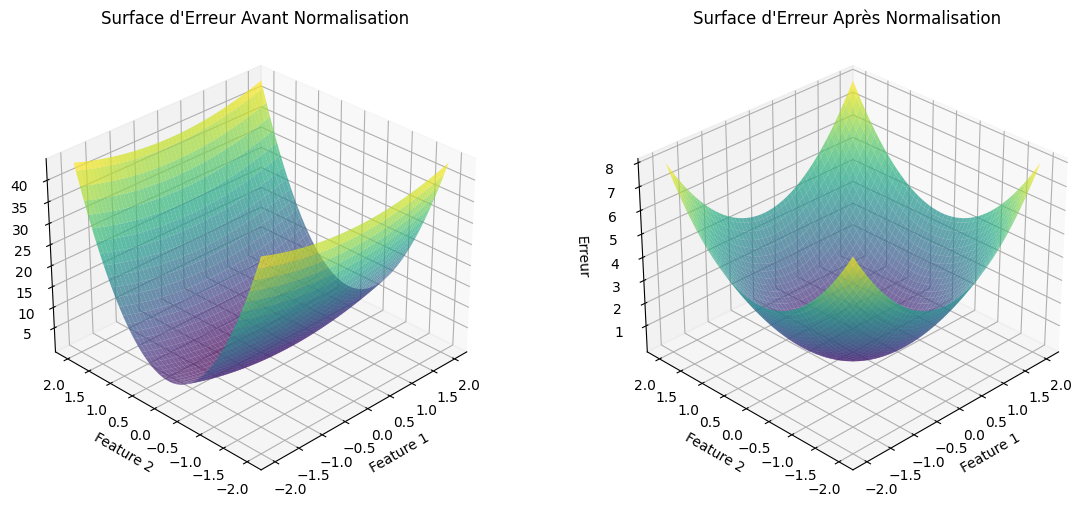

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Fonction pour simuler une surface d'erreur quadratique
def error_surface(x, y, scale_x=1, scale_y=1):
    return scale_x * (x ** 2) + scale_y * (y ** 2)

# Création d'une grille de valeurs pour x et y
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
x, y = np.meshgrid(x, y)

# Surface d'erreur avant normalisation (caractéristiques non normalisées)
z_before = error_surface(x, y, scale_x=1, scale_y=10)

# Surface d'erreur après normalisation (caractéristiques normalisées)
z_after = error_surface(x, y, scale_x=1, scale_y=1)

# Création des graphiques
fig = plt.figure(figsize=(14, 6))

# Diagramme avant normalisation
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(x, y, z_before, cmap='viridis', alpha=0.7)
ax1.set_title('Surface d\'Erreur Avant Normalisation')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_zlabel('Erreur')
ax1.view_init(30, 225)

# Diagramme après normalisation
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(x, y, z_after, cmap='viridis', alpha=0.7)
ax2.set_title('Surface d\'Erreur Après Normalisation')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_zlabel('Erreur')
ax2.view_init(30, 225)

# Affichage des diagrammes
plt.show()
